In [1]:
%matplotlib inline


# mCCA example: Sinusoidal target in separable noise

Reproduced from de Cheveigné et al. (2018).

Synthetic data for this example consisted of 10 data matrices, each of
dimensions 10000 samples x 10 channels. Each was obtained by multiplying 9
Gaussian noise time series (independent and uncorrelated) by a 9 x 10 mixing
matrix with random Gaussian coefficients. To this background of noise was added
a "target" consisting of a sinusoidal time series multiplied by a 1 x 10 mixing
matrix with random coefficients. The target was the same for all data matrices,
but the mixing matrices differed, as were the noise matrices. The SNR was set
to 10−20, i.e. a very unfavorable SNR. The noise is of rank 9 and the signal of
rank 1, so signal and noise are in principle linearly separable.

Uses meegkit.cca.mmca()


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from meegkit import cca

# Set the seed for the random number generator for reproducibility
rng = np.random.default_rng(5)

## Generate toy data
Constants



In [3]:
num_matrices = 10
num_samples = 10000
num_channels = 10
noise_rank = 9
signal_rank = 1
unfavorable_SNR_dB = -20  # SNR in decibels

# Generate noise matrices and mixing matrices
noise_matrices = [rng.normal(size=(num_samples, noise_rank))
                  for _ in range(num_matrices)]
mixing_matrices = [rng.normal(size=(noise_rank, num_channels))
                   for _ in range(num_matrices)]

# Generate sinusoidal target
t = np.linspace(0, 1, num_samples)
target_signal = np.sin(2 * np.pi * t)  # 1 Hz sinusoidal signal

# Generate signal mixing matrix
signal_mixing_matrix = rng.normal(size=(signal_rank, num_channels))

# Prepare data matrices
data_matrices = []
for i in range(num_matrices):
    # Create noise for current data matrix
    noise = np.matmul(noise_matrices[i], mixing_matrices[i])

    # Create signal for current data matrix
    signal = np.matmul(target_signal.reshape(-1, 1), signal_mixing_matrix)

    # Adjust the power of signal to achieve the desired SNR
    noise_power = np.mean(noise**2)
    signal_power = 10**(unfavorable_SNR_dB / 10) * noise_power
    signal = np.sqrt(signal_power / np.mean(signal**2)) * signal

    # Add signal and noise
    data_matrix = signal + noise

    data_matrices.append(data_matrix)

# Concatenate data matrices
x = np.concatenate(data_matrices, axis=-1)

## Use mCCA to recover signal in noise



In [4]:
# Compute Covariance matrix
C = np.dot(x.T, x)

# Compute mCCA from covariance
A, score, AA = cca.mcca(C, 10)

# Compute the recovered signal using first SC
x_recovered = x.dot(A)[:, 0]

# Normalize the recovered signal
x_recovered = x_recovered / x_recovered.std()

# Compute variance across SCs
variance = np.var(x.dot(A), axis=0)

## Plot the results



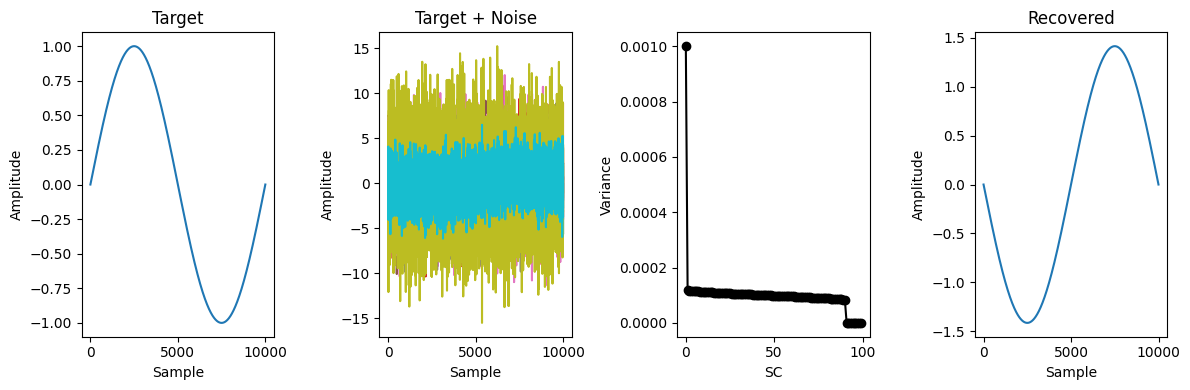

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].plot(target_signal)
ax[0].set_title("Target")
ax[0].set_xlabel("Sample")
ax[0].set_ylabel("Amplitude")
ax[1].plot(data_matrix)
ax[1].set_title("Target + Noise")
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Sample")
ax[2].plot(variance, "o-k")
ax[2].set_xlabel("SC")
ax[2].set_ylabel("Variance")
ax[3].plot(x_recovered)
ax[3].set_title("Recovered")
ax[3].set_ylabel("Amplitude")
ax[3].set_xlabel("Sample")
plt.tight_layout()
plt.show()